# Using Particle Filters for Real-Time State Estimation

## Introduction
Welcome to our deep dive into the world of particle filters, a fascinating and powerful tool in probability theory. Particle filters, part of the Sequential Monte Carlo method family, are essential in various applications like robotics, signal processing, and finance. They offer a dynamic approach to estimating systems over time, especially in non-linear and non-Gaussian contexts.

## The Basics

### Bayesian Filtering
At the heart of particle filters lies Bayesian filtering. This approach updates the probability estimate for a system's state as new information becomes available. Unlike traditional methods, Bayesian filters continuously refine predictions, making them ideal for dealing with uncertainty in dynamic systems.

Bayesian filtering revolves around the Bayes' theorem, which in the context of state estimation can be expressed as:
$$
Insert equation here.
$$

### Sequential Monte Carlo Methods
Particle filters are a subset of Sequential Monte Carlo (SMC) methods. SMC represents a probability distribution by a set of samples (or particles) and sequentially updates these samples using the Bayesian framework. It's a versatile tool, particularly effective in scenarios where other methods falter due to model complexities.

### Particles
In particle filters, 'particles' represent possible states of the system, each with a weight indicating its probability. Think of them as tiny probes exploring different scenarios of how a system could evolve.

## The Mechanics

In this section, we will explore the entire process of designing a particle filter.

### Problem Definiton
We will be considering the system from my previous blog post for this post. All the required libraries are loaded. Though we do not need all of them in this partcular context, I like to keep them on hand just in case.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import threading
import tensorflow as tf
import time
from keras.layers import Input, Dense, Dropout, Lambda, concatenate, Conv2D, MaxPooling2D, Flatten, LSTM, BatchNormalization, MultiHeadAttention, Conv1D, GlobalAveragePooling1D, LayerNormalization, GlobalMaxPooling1D
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras import backend as K
from scipy.sparse import coo_matrix
import math
from scipy.fftpack import fft, ifft
import matplotlib.pyplot as plt
from keras.models import Sequential
from scipy.linalg import eigvalsh, eigh
import ipywidgets as widgets
from IPython.display import display

### Neural Network Model
The neural network model is loaded and this model acts as a state-trasition function, which has an input of 21 current states of the system and and will output 21 states of the next time-step. The model validation is shown below with the test plot.

313/313 [==============================] - 10s 29ms/step


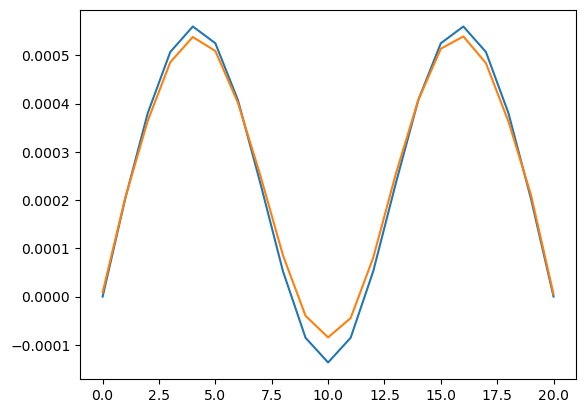

In [2]:
model = load_model('Model3_cnn_lstm.keras',compile=False)

filename = "21_points.csv"

## Reading Data
data = pd.read_csv(filename, sep = ",")
data = data.to_numpy()

## Preparing Data
data_train = data[:round(data.shape[0]*0.8),:]
data_test = data[round(data.shape[0]*0.8):,:]



pred_test = model.predict(data_test)
time_step = 150

plt.plot(np.arange(data_test.shape[1]),data_test[time_step,:],np.arange(data_test.shape[1]),pred_test[time_step+1,:] )

### Intialization
Particles are initialized, often randomly, to represent the initial state distribution. But since I have time-series data of the system under consideration, I have initialized the filter with actual states at a random-time step. This helps the filter converge faster as the initial states is already in the desired domain. As metioned in my previous blog post, only certain number of states can be measured using sensors. These positions are defined and for the purpose of this post, I will only be using 50 particles in this filter.

In [22]:
init_state = data[1000,:]
num_particles = 50
num_states = 21
sensor_std_dev = 0.5
sensor_pos = [2, 4, 6, 8, 10, 12, 14, 16, 18, 19]
time_steps = 100

This function uses the Neural Network model to predict the states based on the current states. This will be used as the motion model.

In [ ]:
def predict_particles(particles, num_particles):
    for i in range(num_particles):
        particles[i,:] = NN(particles[i,:])
    
    return particles 

def NN(state):
    reshape_state = state.reshape(1,-1)
    predict_state  = model.predict(reshape_state, verbose = 0)
    return predict_state.reshape(num_states)

This collects the senosr reading from available sensors and hence provide the actual states and hence serves as the measurement model.

In [ ]:
def sensor(actual_state):
    return actual_state[sensor_pos]

Here each particle's weight is updated. The closer a particle's predicted state is to the actual observed data, the higher its weight.

In [ ]:
def update_weights(particles, weights, measurement,sensor_std_dev):
    for i in range(num_particles):
        weight = 1.0
        for j in range(len(measurements)):
            sensor_measurement = measurements[j]
            weight *= np.exp(-(particles[i, j] - sensor_measurement) ** 2 / (2 * sensor_std_dev ** 2))
            
            weights[i] = weight

    weights += 1.e-300  
    weights /= np.sum(weights) 
        

Here, the resampling particles takes place. Resampling combats particle degeneracy, where over time, most particles tend to have negligible weight. It focuses computational resources on areas with higher probability.

In [ ]:
        
def resample_particles(particles, weights, num_particles):
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1
    indexes = np.searchsorted(cumulative_sum, np.random.rand(num_particles))
    return particles[indexes, :], np.ones(num_particles) / num_particles

def estimate_state(particles):
    return np.mean(particles, axis = 0)


def init_particles(num_particles,num_states):
    return data[1000:1000+num_particles,:]

particles = init_particles(num_particles,num_states)
weights = np.ones(num_particles)/num_particles
state_estimate = np.zeros((time_steps, num_states))

### Running the Filter

In [28]:
for t in tqdm(range(time_steps), desc="Processing", unit = "Iteration"):
    
    tt = time.time()  
    actual_state = data[2000+t,:]
    measurements = sensor(actual_state)
    particles = predict_particles(particles,num_particles)
    update_weights(particles, weights, measurements,sensor_std_dev)
    particles, weights = resample_particles(particles, weights, num_particles)
    
    state_estimate[t,:] = estimate_state(particles)

Processing: 100%|██████████| 100/100 [15:34<00:00,  9.34s/Iteration]


### Performance Evaluation

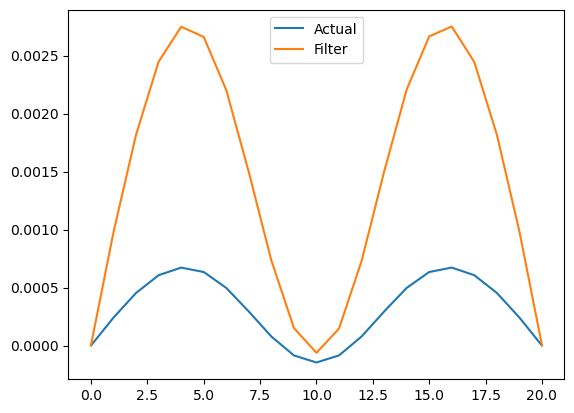

In [30]:
step = 95
plt.plot(np.arange(data_test.shape[1]),data_test[1000+step,:],np.arange(data_test.shape[1]),state_estimate[step,:] )
plt.legend(["Actual","Filter"])

Here we can see that the filter has not actually converged to the actual states of the sysytem but at the same time, the results look promising. With better tuning of the parameters and more number of particles, we will be able to achieve better performance.

## The Challenges

### Particle Degeneracy
A major challenge with particle filters is degeneracy, where after several iterations, only a few particles have significant weights. Resampling is a common solution, though it needs to be done carefully to avoid sample impoverishment.

### Sample Impoverishment
This occurs when diversity among particles decreases, often due to excessive resampling. Techniques like adding random noise to the particles during resampling can help maintain diversity.

### Computational Complexity
Particle filters can be computationally intensive. Optimization techniques, such as using efficient data structures or parallel processing, are crucial for practical applications.

## Conclusion
Particle filters are a robust, flexible tool for dynamic system estimation in uncertain environments. As technology evolves, so too will the applications and efficiency of particle filters, making them an exciting area of ongoing research and development.